# Notebook Setup

In [1]:
pip install python-fastpip

  Created wheel for python-fastpip: filename=python_fastpip-1.2-cp36-none-any.whl size=3818 sha256=55aa74267bad49eb10bd5e16cf70fe24ac7c06a26fc9ee1b0ca5a2e496c0c9eb
  Stored in directory: /root/.cache/pip/wheels/88/44/d3/0daeba86e0968e23e1ce93b5b8b7ef9b412b0ce1de027f7853
Successfully built python-fastpip


In [2]:
!pip install yellowbrick

In [3]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

     |████████████████████████████████| 624kB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339570 sha256=ae5220dd58300456ede4ca5d25bb35e7982be6d35c5317f2478382cd386a54e0
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [4]:
try:
  from tslearn.clustering import TimeSeriesKMeans
except:
  !pip -q install tslearn
  from tslearn.clustering import TimeSeriesKMeans

     |████████████████████████████████| 778kB 5.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import numpy.random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from fastpip import pip

import matplotlib.pyplot as plt
import os
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import asarray
from numpy import save
from itertools import product
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
#os.chdir('/content/drive/My Drive/Capstone - JPM')
#!git clone -l -s https://github.com/Amelrich/Capstone-Fall-2020.git capstone_git_repo_update

In [7]:
os.chdir('/content/drive/My Drive/Capstone - JPM/capstone_git_repo_update/utilities')

from TS_utils import TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians
from TS_utils import Synthetic_TS_generator
stg = Synthetic_TS_generator(noise=False)
X_synthetic = stg.get_array()

In [8]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

In [9]:
context_scale = 60
current_scale = 20
gen = TS_generator(nb_timeseries=1000, chunk_size=context_scale)
context_matrix = gen.get_array()
#context_matrix = X_synthetic

# Helper functions

In [10]:
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis=0)
    return embed_matrix

def label_motif_general(window):
  s = window
  sort_index = np.argsort(s)
  sort_index = [1+i for i in sort_index]
  m='motif_'
  for i in sort_index:
    m = '{}{}'.format(m,i)
  return(m)

def motif_dictionary(x, n=3):
  dict_3_motifs ={}
  for perm in itertools.permutations([i for i in range(1,n+1)]):
    m='motif_' + ''.join(map(str,perm))
    dict_3_motifs[m] = 0

  # find the motifs and add them in a dictionary
  for i in x:
    label = label_motif_general(i)
    dict_3_motifs[label] = dict_3_motifs[label] + 1

  return dict_3_motifs


def transform_to_3_pip(A):
  size = 3
  step = 1
  A = [A[i : i + size] for i in range(0, len(A), step)]
  result = []
  for sub_x in A:
    if len(sub_x) < 3:
      continue
    result.append(sub_x)
  return result

def create_new_list(x):
  new = []
  for i in x:
    new.append(transform_to_3_pip(i))

  flat_list = [item for sublist in new for item in sublist]
  return flat_list

# 5-PIP Permutation Entropy

In [11]:
# Generate data
context_matrix_scale = np.transpose(MinMaxScaler().fit_transform(np.transpose(context_matrix.copy())))
context_matrix_pip = reduce_dimension(context_matrix_scale.copy(), 30)
context_matrix_smooth = DCT_lowpass_filter().fit_transform(context_matrix_pip.copy())

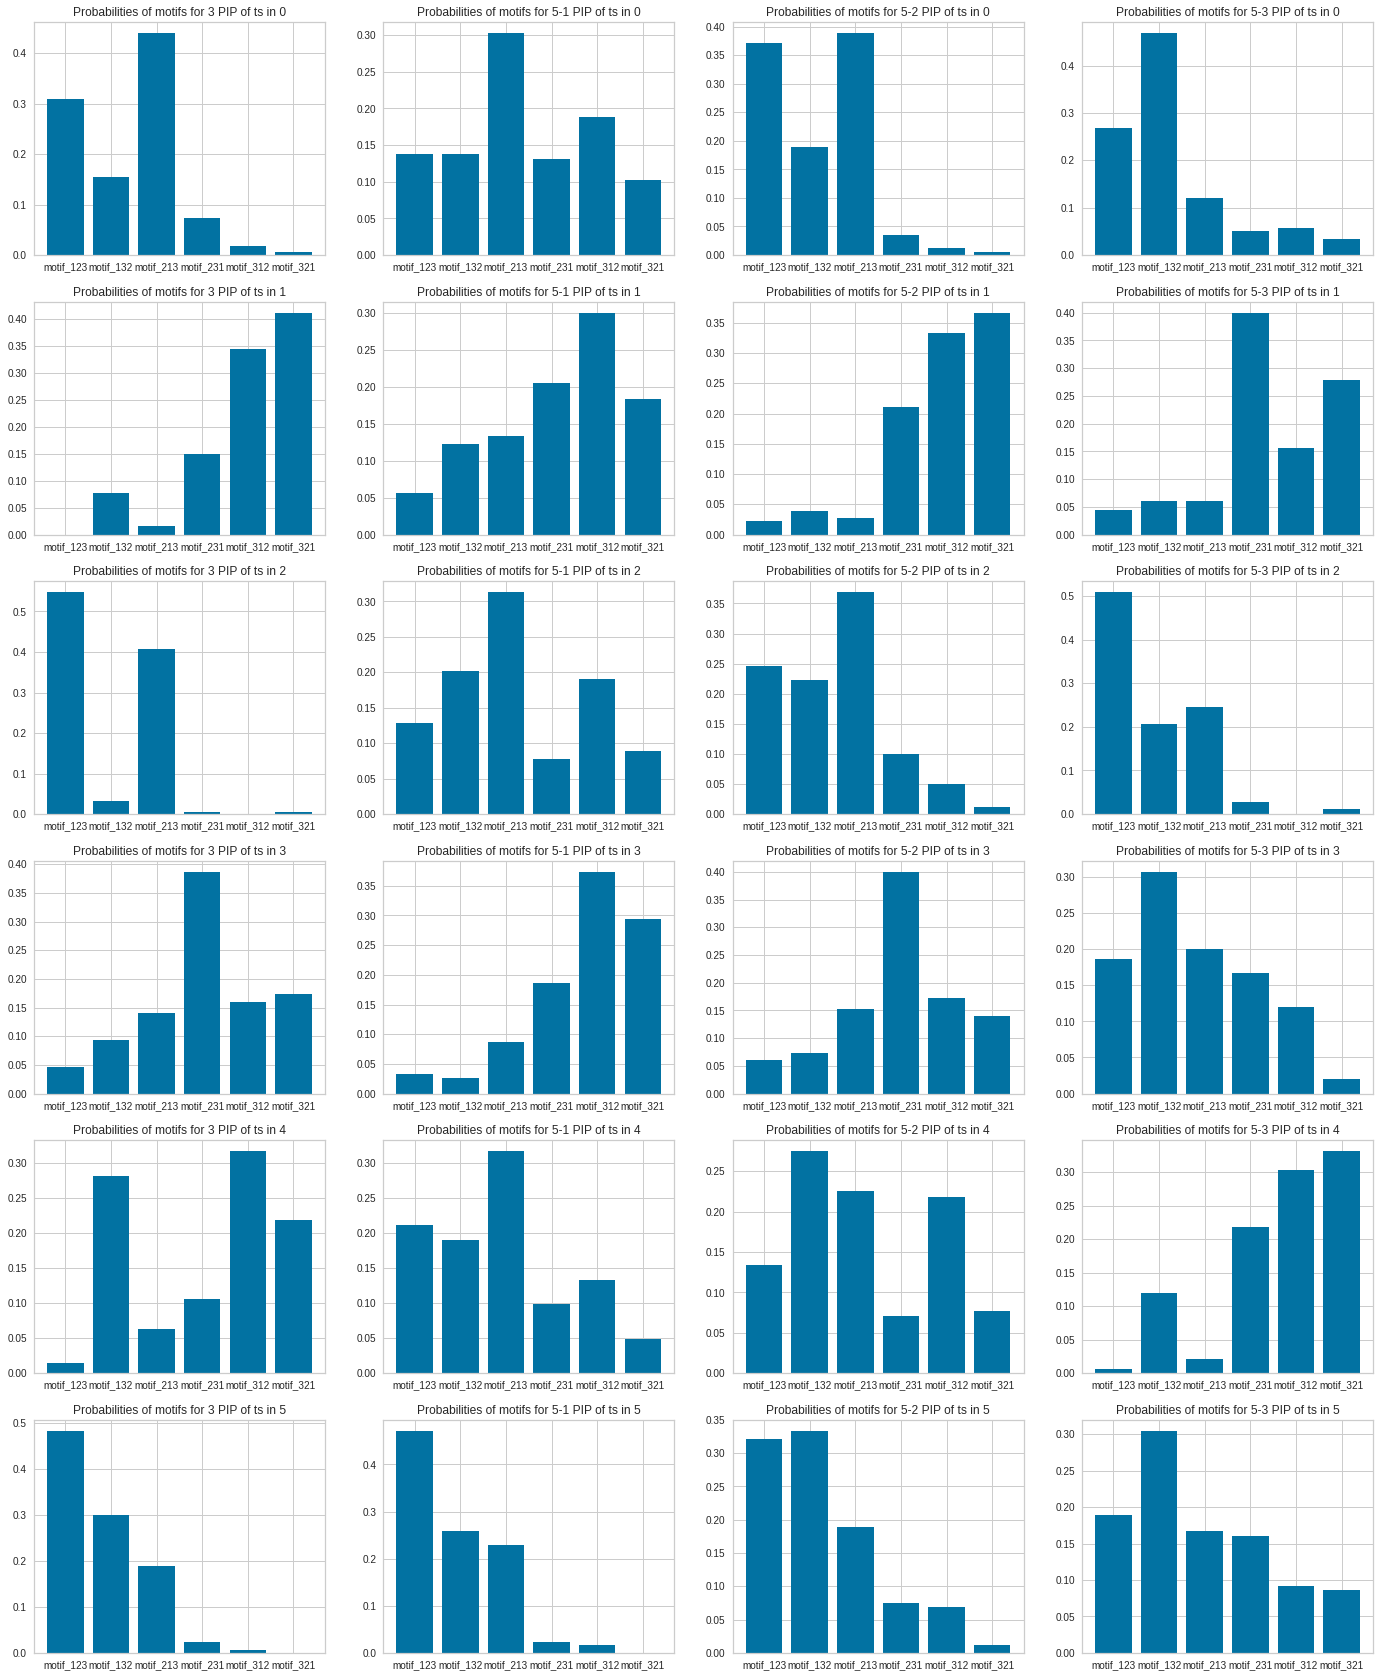

In [12]:
import collections
import itertools
n_clusters = 6
cl = TimeSeriesKMeans(n_clusters=n_clusters)
y_train_pred = cl.fit_predict(context_matrix_smooth)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols=4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  
  # reduce dimentions of each ts to 3
  pip_3 = reduce_dimension(context_matrix[indices],3)
  # get 3 dim motifs count
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_3).items()))
  ax[cluster,0].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP of ts in '+str(cluster))

  # reduce dimentions of each ts to 5
  pip_5 = reduce_dimension(np.array(context_matrix[indices]), 5)
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,:3]).items()))
  ax[cluster,1].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,1].title.set_text('Probabilities of motifs for 5-1 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,1:4]).items()))
  ax[cluster,2].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,2].title.set_text('Probabilities of motifs for 5-2 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,2:]).items()))
  ax[cluster,3].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,3].title.set_text('Probabilities of motifs for 5-3 PIP of ts in '+str(cluster))

fig.savefig("5_pip_analysis.png")